In [1]:
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn import Embedding 
from torch.optim import SGD,Adam
from torch.nn import CrossEntropyLoss, BCELoss, MSELoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
from numpy import vstack
from sklearn.decomposition import PCA
from torch.utils.data import random_split
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# model definition
class RNN(Module):
    # define model elements
    # n_inputs: input dimension
    # n_hidden: number of neurons per layer
    # n_layers: number of hidden layers
    def __init__(self, n_hidden, n_layers, input_dim):
        super(RNN, self).__init__()
        
        # hidden layers
        #self.embed = Embedding(input_dim, embedding_dim) 
        self.hidden = {}
        self.act = {}
        for i in range(n_layers):
            if i==0:
                n_in = input_dim + n_hidden # embedding_dim + n_hidden
            else:
                n_in = n_hidden * 2
            # input to hidden layer
            self.hidden[i] = Linear(n_in, n_hidden)
            kaiming_uniform_(self.hidden[i].weight, nonlinearity='relu')
            # non-linearity
            self.act[i] = Tanh() # or ReLu
        
        # output
        self.out = Linear(n_hidden,input_dim) # dimension of output is 2
        xavier_uniform_(self.out.weight)
        #self.actout = Sigmoid()
        
        
    # forward propagate input
    def forward(self, X, hidden_layer):
        n_layers = len(hidden_layer)
        #idx = torch.argmax(X,-1)
        #embedding = self.embed(idx)
        for i in range(n_layers):
            if i == 0:
                # combine input with previous hidden
                combined = torch.cat((X, hidden_layer[i]), 1)
            else:
                # combine previous hidden with hidden
                combined = torch.cat((hidden_layer[i-1], hidden_layer[i]), 1)
            # input to hidden layer
            hidden_layer[i] = self.hidden[i](combined)
            hidden_layer[i] = self.act[i](hidden_layer[i])
            
        ## output
        output = self.out(hidden_layer[i])
        #output = self.actout(output)

        return output,hidden_layer

In [3]:
# train the model
def train_model(train_x,train_y, model):
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]
    # define the optimization
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=0.05)
    
    # enumerate epochs
    all_loss = []
    lossdiff = -1
    epoch = 0
    while lossdiff<0:
        # enumerate batches (xx and xY batch)    
        for xi,yi in zip(train_x,train_y):
            # clear the gradients
            optimizer.zero_grad()
            # initialise hidden states
            batch_size = xi.size()[0]
            hi = {}
            for k in range(n_layers):
                hi[k] = torch.zeros((batch_size,n_hidden))
            #loss = 0
            for j in range(xi.size()[1]):
                xij = xi[:,j,:]

                # compute the model output
                yhat,hi = model(xij,hi)
                
                for k in range(n_layers):
                    hi[k] = hi[k].detach()
            # calculate loss on last prediction
            loss = criterion(yhat, yi)
            loss.backward(retain_graph=True)
            
            # update model weights
            optimizer.step()
        
        all_loss.append(loss.item())  
        if epoch>5:
            lossdiff = all_loss[-1]-np.mean(all_loss[-5:-1] )
        epoch +=1
    return all_loss

# evaluate the model
def evaluate_model(test_x,test_y, model):
    
    # this function returns the average accuracy on all input test sequences. One value per sequence
    # For now, it skips the first  items
    
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    
    num_seq = len(test_x)
    acc = []
    rand_acc = []
    for xi,yi in zip(test_x,test_y):
        batch_size = xi.size()[0]
        # initialize hidden state
        hi = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))

        for j in range(xi.size()[1]):
            xij = xi[:,j,:]
            # compute the model output
            yhat,hi = model(xij,hi)
            
        # round to class values: this is if output is classification
        #yhat = np.argmax(yhat.detach().numpy(),-1)
        # store
        #acc.append(accuracy_score(yhat.detach().numpy(),yi))
        
        
        # if regression:
        yhat = yhat.detach().numpy()
        acc.append(np.mean((yhat-yi.numpy())**2))

    return acc 

def predict(x,model):
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    
    y = []
    h = []
    c = []
    for xi in x:
        batch_size = xi.size()[0]
        hi = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))
        
        for j in range(xi.size()[1]):
            xij = xi[:,j,:]
            # compute the model output
            yhat,hi = model(xij,hi)
            
        yhat = yhat.detach().numpy() # predicted stimulus
        #ci = np.round(yhat) != xij.detach().numpy()
        ##print(np.sum(ci,1))
        #ci =  ((np.sum(ci,1)==0)==False).astype(int) # predicted sameness 1=change, 0=same
        y.append(yhat)
        #c.append(ci)
        h.append(hi)
        
    return y,h #,c


Create input sequences

In [4]:
def unique_pairs(dictionary):
    '''
    create matrix with unique pairs of (one-hot) vectors in dictionary
    
    dictionary: N x dimensionality; matrix of N (one-hot) vectors
    '''
    vecpairs = []
    for i in range(dictionary.shape[0]):
        for j in range(dictionary.shape[0]):
            if i!=j:
                vecpairs.append(np.vstack((dictionary[j,],dictionary[i,])))
    vecpairs = np.array(vecpairs) 
    return vecpairs

def unique_pairs_sequence(seq,repeats,pairs):
    
    '''
    Create a structured sequence such as 010101, replacing 0 and 1 with (one-hot) vectors from dictionary
    
    batch_size: number of sequence samples with different value for 0 and 1
    seq: list of sequence structures
    repeats: repeats per sequence chunk (e.g. 4 = 4xsize of sequence chunk)
    dictionary: matrix of (one-hot) vectors, shape: dic size X input size
    '''
    nseq = len(seq)
    x = np.zeros((nseq))
    input_size = pairs.shape[2]
    batch_size = pairs.shape[0]
    all_seq = []
    seq_len = []
    for s in seq:
        
        # pick value from dictionary:
        a = []
        b = []
        for i in range(batch_size):
            a.append(pairs[i,1,:]) # X
            b.append(pairs[i,0,:]) # Y
        a = np.array(a)
        b = np.array(b)
        # create sequence
        sequence = []
        for i,element in enumerate(s):
            if element==0:
                sequence.append(a)
            elif element==1:
                sequence.append(b)
        sequence = np.array(sequence)
         
        sequence = np.swapaxes(sequence,0,1)
        # add zero state
        sequence = np.concatenate((sequence,np.zeros((batch_size,1,input_size))),1)
        out_sequence = sequence
        for r in range(repeats-1):
            # stack the sequence repeat times
            out_sequence = np.concatenate((out_sequence,sequence),1)
        all_seq.append(out_sequence)

    return all_seq


### Training & Testing on structure switch

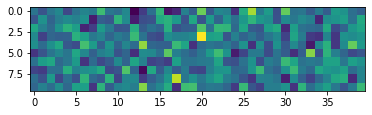

200 units per layer, 1 layer


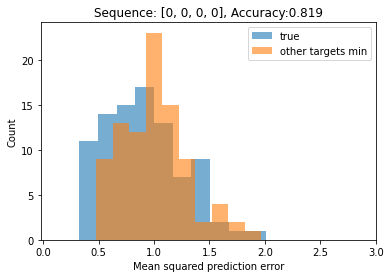

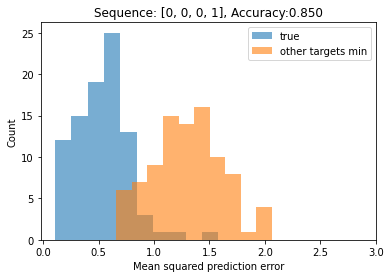

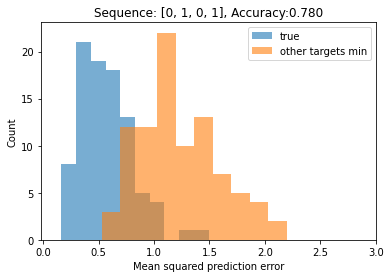

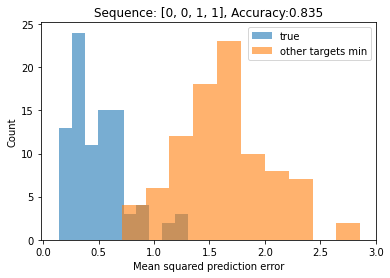

In [7]:
seq = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1]] # sequence structures to be used
seq_test = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1]]
seq_test2 = [[0,0,0,1],[0,0,0,0],[0,1,0,0],[0,0,1,0]] # those are the global deviants
Nseq = len(seq_test)
repeats = 10 # repeats per chunk in each sequence
input_size = 40 # dimensionality of the input
dict_size = 10 # size of stimulus dictionary
n_hidden = 200
n_layers = 1

Nback = 5*3 # number of items from last to be predicted 

ntrials = dict_size*dict_size - dict_size
Acc = np.zeros((Nseq,Nback,ntrials))
AngleAll = np.zeros((Nseq,Nback,ntrials,dict_size))

# produce random stimuli:
dictionary = np.random.randn(dict_size,input_size) # use same size as for the one-hot encoding
    
plt.imshow(dictionary)
plt.show()
    
# get unique pairs of stimuli
pairs = unique_pairs(dictionary)
    
# create training and test data
sequence = unique_pairs_sequence(seq,repeats,pairs)
test_sequence = unique_pairs_sequence(seq_test,repeats,pairs)
test_sequence2 = unique_pairs_sequence(seq_test2,2,pairs)
# concatenate both test sequences
for i in range(len(seq_test)):
    test_sequence[i] = np.concatenate((test_sequence[i],test_sequence2[i]),1)
    

print('%s units per layer, %s layer'%(n_hidden,n_layers))
Yhat = np.zeros((ntrials,len(test_sequence),Nback,input_size)) # store prediction here
Ytrue = np.zeros((ntrials,len(test_sequence),Nback,input_size)) # store ground truth
Hidden = np.zeros((ntrials,len(test_sequence),Nback,n_hidden)) # hidden state activity
for k in range(ntrials):
    
    train_x = []
    train_y = []
    # create data from numpy arrrays
    for i in range(len(seq)):
        if i==0:#delete all occurrences of that stimulus
            trainind = np.delete(np.arange(ntrials),np.arange(int(k/dict_size)*(dict_size-1),(int(k/dict_size)+1)*(dict_size-1)))
        else:
            trainind = np.delete(np.arange(ntrials),k)
        train_x.append(torch.Tensor(sequence[i][trainind,:-2,:])) #!!-1 if no zero element after each chunk, otherwise -2
        train_y.append(torch.Tensor(sequence[i][trainind,-2,:])) #-2 because last element is zero state

    # train network
    model = RNN(n_hidden,n_layers,input_size)
    Loss = train_model(train_x,train_y, model)
    
    # predict last N=5*3 items of sequence; + 3 for zero states
    for j in range(Nback):
        
        test_x = []
        for i in range(Nseq):
            if j==Nback-1:
                test_x.append(torch.Tensor(test_sequence[i][k:k+1,:,:]))
            else:
                test_x.append(torch.Tensor(test_sequence[i][k:k+1,:-Nback+j+1 ,:]))

        y,h = predict(test_x,model)
    
        for i in range(Nseq):
            Yhat[k,i,j,:] = y[i][0,:] # hard coded!, works only if output 1 sample
            if j==Nback-1:
                Ytrue[k,i,j,:] = test_sequence[i][k,-5,:]
            else:
                Ytrue[k,i,j,:] = test_sequence[i][k,-Nback+j+1 ,:] # last item is zero state
            Hidden[k,i,j,:] = h[i][0][0,:].detach().numpy()
        

Error = np.zeros((len(test_sequence),ntrials))
Errordist = np.zeros((len(test_sequence),ntrials,dict_size-1))

for i in range(len(test_sequence)):
    for j in range(Nback): # items in sequence
        for k in range(ntrials):
            yhat = Yhat[k,i,j,:]
            ytrue = Ytrue[k,i,j,:]
            yrep = np.repeat(ytrue[None,:],dict_size,0)
            target_idx = np.argmin(np.mean(abs(yrep-dictionary),1))
            Error[i,k] = np.mean((yhat - ytrue)**2) # calculate mean squared error of predicted vector with ground truth
            yrep = np.repeat(yhat[None,:],dict_size-1,0)
            Errordist[i,k,:] = np.mean((yrep - np.delete(dictionary,target_idx,0))**2,1) # calculate mean squared error of predicted vector with ground truth
            # calculate ratio of samples equally small or smaller than sample
            Acc[i,j,k] = Error[i,k]<np.min(Errordist[i,k,]) #(np.min(Errordist[i,k,])-Error[i,k])/np.min(Errordist[i,k,]) 
        
            # angle with all vectors in dictionary
            yrep = np.repeat(yhat[None,:],dict_size,0)
            yrep = yrep/np.linalg.norm(yrep,1)
            dic = dictionary/np.linalg.norm(dictionary,1)
            for s in range(dict_size):
                AngleAll[i,j,k,s] = yrep[s,:]@dic[s,:]#) * 180/np.pi
            
    ax = plt.subplot(111)
    plt.hist(Error[i,],label='true',alpha=.6)
    plt.hist(np.min(Errordist[i,],-1),label='other targets min',alpha=.6)
    ax.set_title('Sequence: %s, Accuracy:%.3f'%(seq_test[i],np.mean(Acc[i,:])))
    ax.set_xlabel('Mean squared prediction error')
    ax.set_xlim(-0.02,3)
    plt.ylabel('Count')
    plt.legend()
    #plt.savefig('NIP_error_seq_%s.png'%seq_test[i])
    plt.show()

### Visualize results

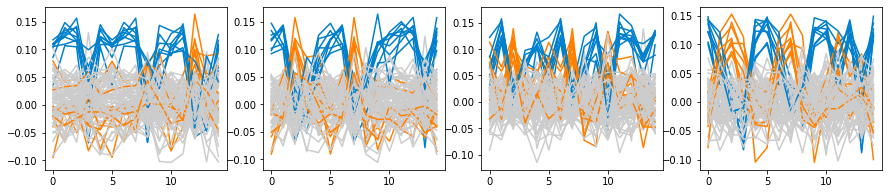

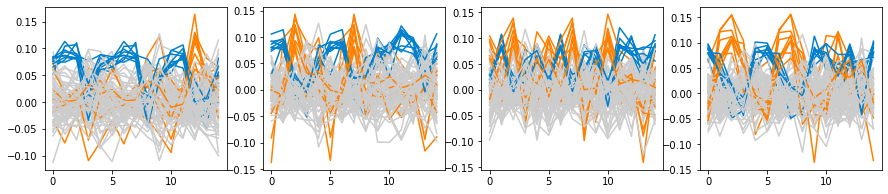

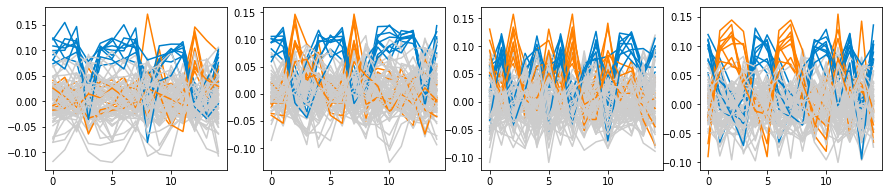

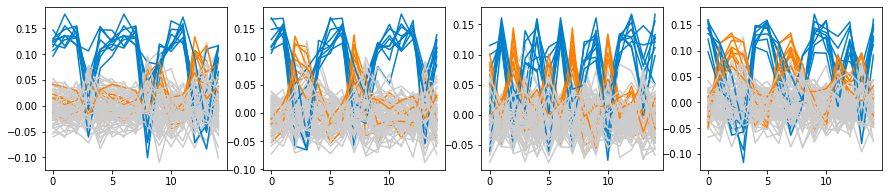

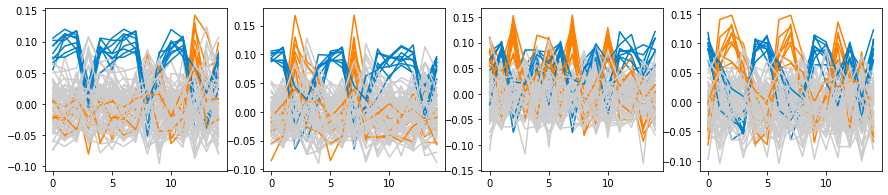

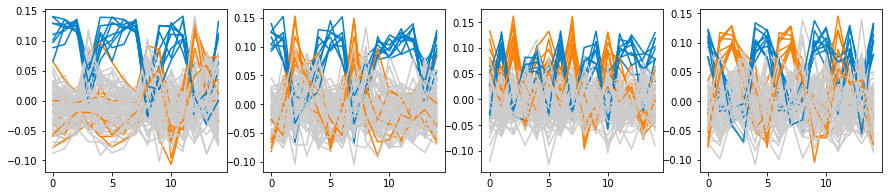

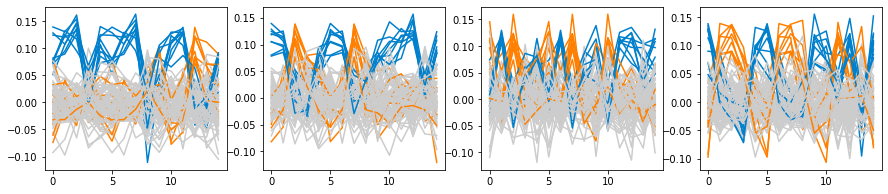

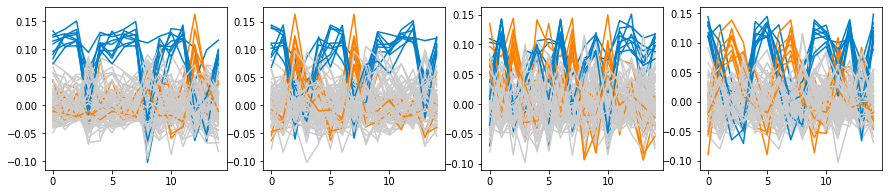

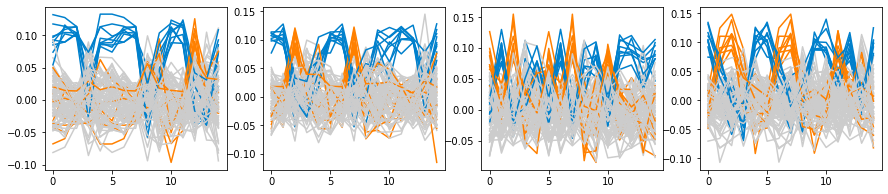

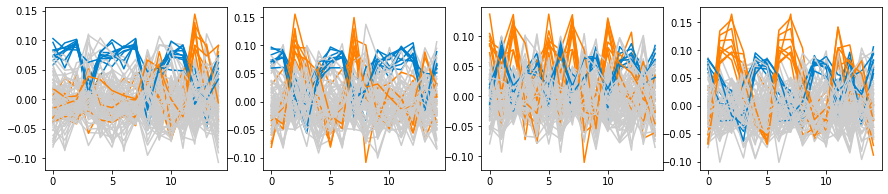

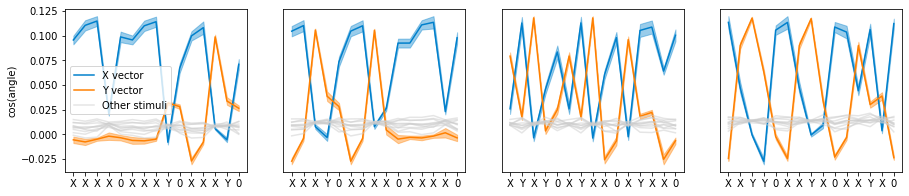

In [196]:
# PLOT ANGLE FOR EACH STIMULUS X WITH ITS CORRESPONDING VECTOR AND THE OTHER VECTOR Y
N = Nback
xlabels = ['X','Y','0'] # for correct x ticks
dict_size = dictionary.shape[0]
second_stim = []
AllResp = np.zeros((Nseq,n_stim,n_stim-1,n_stim,N))
test_seq = []

for i in range(len(seq_test)):
    test_seq.append(np.concatenate((seq_test[i],[2],seq_test2[i],[2],seq_test2[i],[2]))) 
    # this is the sequence evaluated in the previous cell
    

for stimulus in range(n_stim): # loop through all stimuli
    fig,ax = plt.subplots(1,Nseq,figsize=(15,3))
    for which_seq in range(Nseq): # loop through sequences
        other_stimuli = np.delete(np.arange(n_stim),stimulus)
        for n in range(n_stim-1): # loop through other stimuli
            which_stim = [stimulus,other_stimuli[n]]
            remaining = np.delete(np.arange(n_stim),which_stim) # these are the other stimuli
            for i in range(n_stim):
            
                if i==0:
                    col= [0,.5,.8]
                    ii = which_stim[i]
                elif i==1:
                    col = [1,.5,0]
                    ii = which_stim[i]
                else:
                    col= [.8,.8,.8]
                    ii = remaining[i-2]
                
                    
                AllResp[which_seq,stimulus,n,i,:] = AngleAll[which_seq,:,stimulus*(n_stim-1)+n%(n_stim-1),ii]
                ax[which_seq].plot(np.arange(N),AngleAll[which_seq,:,stimulus*(n_stim-1)+n%(n_stim-1),ii],color=col)
plt.show()

fig,ax = plt.subplots(1,Nseq,figsize=(15,3))
col = [[0,.5,.8],[1,.5,0]]
for which_seq in range(Nseq):
    for i in range(2):
        m = np.mean(np.mean(AllResp[which_seq,:,:,i,],1),0)
        sem = np.std(np.mean(AllResp[which_seq,:,:,i,],1),0)/np.sqrt(n_stim)
        ax[which_seq].plot(np.arange(N),m,color=col[i])
        ax[which_seq].fill_between(np.arange(N),m-sem,m+sem,color=col[i],alpha=.4)
    m = np.mean(np.mean(AllResp[which_seq,:,:,:,],2),1).T
    ax[which_seq].plot(np.arange(N),m,color=[.8,.8,.8],alpha=.5)
    ax[which_seq].set_xticks(np.arange(N))
    ticks = []
    for t in range(N):
        ticks.append(xlabels[test_seq[which_seq][t]])
    ax[which_seq].set_xticklabels(ticks)
    if which_seq>0:
        ax[which_seq].set_yticks(())
    ax[0].set_ylabel('cos(angle)')
    ax[0].legend(['X vector','Y vector','Other stimuli'])
plt.savefig('NIP_Angles.pdf')
plt.show()



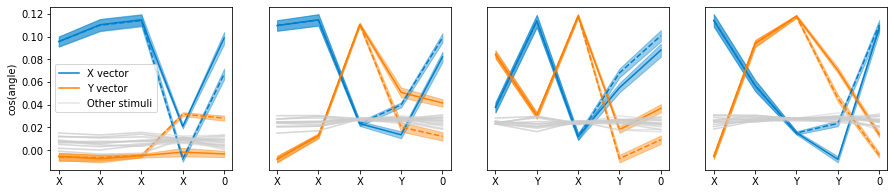

In [198]:
fig,ax = plt.subplots(1,Nseq,figsize=(15,3))
col = [[0,.5,.8],[1,.5,0]]
markers = ['-','--']
for which_seq in range(Nseq):
    for n in range(2):
        for i in range(2):
        
            m = np.mean(np.mean(AllResp[which_seq,:,:,i,5*n:5*(n+1)],1),0)
            sem = np.std(np.mean(AllResp[which_seq,:,:,i,5*n:5*(n+1)],1),0)/np.sqrt(n_stim)
            ax[which_seq].plot(np.arange(5),m,color=col[i],linestyle=markers[n])
            ax[which_seq].fill_between(np.arange(5),m-sem,m+sem,color=col[i],alpha=.4)
        m = np.mean(np.mean(AllResp[which_seq,:,:,:,5*n:5*(n+1)],2),1).T
        ax[which_seq].plot(np.arange(5),m,color=[.8,.8,.8],alpha=.5)
    ax[which_seq].set_xticks(np.arange(5))
    ticks = []
    for t in range(5):
        ticks.append(xlabels[test_seq[which_seq][t]])
    ax[which_seq].set_xticklabels(ticks)
    if which_seq>0:
        ax[which_seq].set_yticks(())
    ax[0].set_ylabel('cos(angle)')
    ax[0].legend(['X vector','Y vector','Other stimuli'])
plt.savefig('NIP_Angles_Overlay.pdf')
plt.show()



Probe global effect by overlaying response to predicted and unpredicted xxxY and xxxx

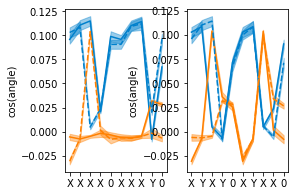

In [202]:
# xxxx
seq = [0,1]
timewindow = [0,1]
fig,ax = plt.subplots(1,2,figsize=(4,3))
for i,s in enumerate(seq):
    n = timewindow[i]
    for i in range(2):
    
        m = np.mean(np.mean(AllResp[s,:,:,i,5*n:10*(n+1)],1),0)
        sem = np.std(np.mean(AllResp[s,:,:,i,5*n:10*(n+1)],1),0)/np.sqrt(n_stim)
        ax[0].plot(np.arange(10),m,color=col[i],linestyle=markers[n])
        ax[0].fill_between(np.arange(10),m-sem,m+sem,color=col[i],alpha=.4)
    #m = np.mean(np.mean(AllResp[which_seq,:,:,:,5*n:9*(n+1)],2),1).T
    #ax[0].plot(np.arange(9),m,color=[.8,.8,.8],alpha=.5)
    ax[0].set_xticks(np.arange(10))
    ticks = []
    for t in range(10):
        ticks.append(xlabels[test_seq[0][t]])
    ax[0].set_xticklabels(ticks)
    #if which_seq>0:
     #   ax[which_seq].set_yticks(())
    ax[0].set_ylabel('cos(angle)')
    #ax[0].legend(['X vector','Y vector','Other stimuli'])
#plt.savefig('NIP_Angles_Overlay.pdf')

seq = [1,0]
timewindow = [0,1]
for i,s in enumerate(seq):
    n = timewindow[i]
    for i in range(2):
    
        m = np.mean(np.mean(AllResp[s,:,:,i,5*n:10*(n+1)],1),0)
        sem = np.std(np.mean(AllResp[s,:,:,i,5*n:10*(n+1)],1),0)/np.sqrt(n_stim)
        ax[1].plot(np.arange(10),m,color=col[i],linestyle=markers[n])
        ax[1].fill_between(np.arange(10),m-sem,m+sem,color=col[i],alpha=.4)
    #m = np.mean(np.mean(AllResp[which_seq,:,:,:,5*n:9*(n+1)],2),1).T
    #ax[0].plot(np.arange(9),m,color=[.8,.8,.8],alpha=.5)
    ax[1].set_xticks(np.arange(10))
    ticks = []
    for t in range(10):
        ticks.append(xlabels[test_seq[2][t]])
    ax[1].set_xticklabels(ticks)
    #if which_seq>0:
     #   ax[which_seq].set_yticks(())
    ax[1].set_ylabel('cos(angle)')
    #ax[0].legend(['X vector','Y vector','Other stimuli'])
#plt.savefig('NIP_Angles_Overlay.pdf')
plt.show()
    

### PCA with global deviants

In [10]:
n_comp = 20
Proj = np.zeros((ntrials,Nseq,Nback,n_comp))
Varexp = np.zeros((ntrials,n_comp))
PCs = np.zeros((ntrials,n_comp,n_hidden))
n_pos = 5

for i in range(ntrials):
    hidden = np.reshape(Hidden[i,:,1:n_pos+1,:],(Nseq*n_pos,n_hidden))
    hidden_all = np.reshape(Hidden[i,:,:,:],(Nseq*Nback,n_hidden))
    principal = PCA(n_components = n_comp)
    principal.fit(hidden)
    x = principal.transform(hidden_all)
    proj = np.reshape(x,(Nseq,Nback,n_comp))
    Proj[i,:,:,:] = proj
    Varexp[i,:]  = principal.explained_variance_ratio_
    PCs[i,:,:] = principal.components_

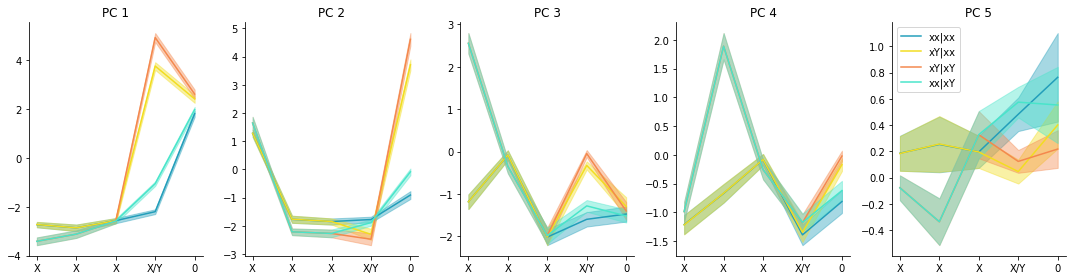

In [21]:
# visualize global standards and errors
ticks = ['X','X','X','X/Y','0']
colors = [['#229eba','#f2dd20'], # xx block
         ['#f4884d','#48e5ca']] # xY block
labels = [['xx|xx','xY|xx'],['xY|xY','xx|xY']]

plot_comp = 5
fig,ax = plt.subplots(1,plot_comp,figsize=(plot_comp*3,4))
for c in range(plot_comp):
    for i in range(2):
        for j in range(2):
            m = np.mean(Proj[:,i,j*5:(j+1)*5,c],0)
            sem = np.std(Proj[:,i,j*5:(j+1)*5,c],0)/np.sqrt(ntrials)
            ax[c].plot(np.arange(5),m,color=colors[i][j],label=labels[i][j])
            ax[c].fill_between(np.arange(5),m-sem,m+sem,color=colors[i][j],alpha=.4)
    ax[c].set_xticks(np.arange(5))
    ax[c].set_xticklabels(ticks)
    ax[c].set_title('PC %s'%(c+1))
    ax[c].spines['top'].set_visible(False)
    ax[c].spines['right'].set_visible(False)
plt.tight_layout()
plt.legend()
plt.savefig('NIP_PCA_Trialtypes.pdf')
plt.savefig('NIP_PCA_Trialtypes.png')
plt.show()